In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model


from sklearn.model_selection import TimeSeriesSplit

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16784919312506522348
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14224482712901815949
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [5]:
train_dir = '/content/drive/MyDrive/Data/'

In [6]:
TRAIN = pd.read_csv(train_dir+'full_train_met.csv')
TRAIN.head()

,year,month,day,delta_stage_max,lat,lon,distance_from_source,drainage_area,z_null,aet_12,aet_11,aet_10,aet_9,aet_8,aet_7,aet_6,aet_5,aet_4,aet_3,aet_2,aet_1,Cm,J,K,N,O,X,Z,horizontal_visibility,cloud_amount_total,cloud_base_altitude,wind_direction,wind_speed_aver,soil_surface_temperature,air_temperature,water_vapour_partial_pressure,relative_humidity,vapour_pressure_deficit,dew_point_temperature,pressure,pressure_sea_level,barometric_tendency,soil_surface_alco_temperature,soil_surface_max_temperature,air_temperature_max_before,air_max_temperature,weather_before,weather,air_temperature_wet_bulb_qual_1,barometric_tendency_characteristic,precipitation,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_density_aver,ice_crust_aver,water_total,snow_coverage_charact,snow_charact,snow_height,snow_coverage_station,temperature_240cm,precipitation_observed,precipitation_corrected,sunshine_hours,delta_temp20_80,delta_temp40_120,delta_temp160_320
0,1985,1,1,0.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1985,1,2,0.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,1,3,0.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,1,4,-1.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,1,5,0.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
TEST = pd.read_csv(train_dir+'full_test_met.csv')
TEST.head()

,year,month,day,lat,lon,distance_from_source,drainage_area,z_null,aet_12,aet_11,aet_10,aet_9,aet_8,aet_7,aet_6,aet_5,aet_4,aet_3,aet_2,aet_1,Cm,J,K,N,O,X,Z,horizontal_visibility,cloud_amount_total,cloud_base_altitude,wind_direction,wind_speed_aver,soil_surface_temperature,air_temperature,water_vapour_partial_pressure,relative_humidity,vapour_pressure_deficit,dew_point_temperature,pressure,pressure_sea_level,barometric_tendency,soil_surface_alco_temperature,soil_surface_max_temperature,air_temperature_max_before,air_max_temperature,weather_before,weather,air_temperature_wet_bulb_qual_1,barometric_tendency_characteristic,precipitation,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_density_aver,ice_crust_aver,water_total,snow_coverage_charact,snow_charact,snow_height,snow_coverage_station,temperature_240cm,precipitation_observed,precipitation_corrected,sunshine_hours,delta_temp20_80,delta_temp40_120,delta_temp160_320
0,1993,4,111,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1993,4,112,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1993,4,113,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1993,4,114,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1993,4,115,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
list(TRAIN.columns)

['year',
 'month',
 'day',
 'delta_stage_max',
 'lat',
 'lon',
 'distance_from_source',
 'drainage_area',
 'z_null',
 'aet_12',
 'aet_11',
 'aet_10',
 'aet_9',
 'aet_8',
 'aet_7',
 'aet_6',
 'aet_5',
 'aet_4',
 'aet_3',
 'aet_2',
 'aet_1',
 'Cm',
 'J',
 'K',
 'N',
 'O',
 'X',
 'Z',
 'horizontal_visibility',
 'cloud_amount_total',
 'cloud_base_altitude',
 'wind_direction',
 'wind_speed_aver',
 'soil_surface_temperature',
 'air_temperature',
 'water_vapour_partial_pressure',
 'relative_humidity',
 'vapour_pressure_deficit',
 'dew_point_temperature',
 'pressure',
 'pressure_sea_level',
 'barometric_tendency',
 'soil_surface_alco_temperature',
 'soil_surface_max_temperature',
 'air_temperature_max_before',
 'air_max_temperature',
 'weather_before',
 'weather',
 'air_temperature_wet_bulb_qual_1',
 'barometric_tendency_characteristic',
 'precipitation',
 'snow_coverage_near_station',
 'snow_coverage_route',
 'ice_crust_route',
 'snow_height_aver',
 'snow_density_aver',
 'ice_crust_aver',
 'w

In [8]:
features = [
            'year',
            'month',
            'day',
            'lat',
            'lon',
            'distance_from_source',
            'drainage_area',
            'z_null',
            'aet_12',
            'aet_11',
            'aet_10',
            'aet_9',
            'aet_8',
            'aet_7',
            'aet_6',
            'aet_5',
            'aet_4',
            'aet_3',
            'aet_2',
            'aet_1',
            'Cm',
            'J',
            'K',
            'N',
            'O',
            'X',
            'Z',
            'horizontal_visibility',
            'cloud_amount_total',
            'cloud_base_altitude',
            'wind_direction',
            'wind_speed_aver',
            'soil_surface_temperature',
            'air_temperature',
            'water_vapour_partial_pressure',
            'relative_humidity',
            'vapour_pressure_deficit',
            'dew_point_temperature',
            'pressure',
            'pressure_sea_level',
            'barometric_tendency',
            'soil_surface_alco_temperature',
            'soil_surface_max_temperature',
            'air_temperature_max_before',
            'air_max_temperature',
            'weather_before',
            'weather',
            'air_temperature_wet_bulb_qual_1',
            'barometric_tendency_characteristic',
            'precipitation',
            'snow_coverage_near_station',
            'snow_coverage_route',
            'ice_crust_route',
            'snow_height_aver',
            'snow_density_aver',
            'ice_crust_aver',
            'water_total',
            'snow_coverage_charact',
            'snow_charact',
            'snow_height',
            'snow_coverage_station',
            'temperature_240cm',
            'precipitation_observed',
            'precipitation_corrected',
            'sunshine_hours',
            'delta_temp20_80',
            'delta_temp40_120',
            'delta_temp160_320'

]

target = [ 
            'delta_stage_max',
]

In [9]:
len(features)

68

In [14]:
X = TRAIN[features]
y = TRAIN[target]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [15]:
input_data = Input(len(features))

dense_1 = Dense(200, activation='relu')(input_data)
dense_1 = Dropout(0.1)(dense_1)
dense_1 = Dense(50, activation='relu')(dense_1)
dense_1 = BatchNormalization()(dense_1)
dense_1 = Dense(10, activation='relu')(dense_1)

dense_2 = Dense(200, activation='LeakyReLU')(input_data)
dense_2 = Dropout(0.1)(dense_2)
dense_2 = Dense(50, activation='LeakyReLU')(dense_2)
dense_2 = BatchNormalization()(dense_2)
dense_2 = Dense(10, activation='LeakyReLU')(dense_2)


dense_3 = Dense(200, activation='tanh')(input_data)
dense_3 = Dropout(0.1)(dense_3)
dense_3 = Dense(50, activation='tanh')(dense_3)
dense_3 = BatchNormalization()(dense_3)
dense_3 = Dense(10, activation='tanh')(dense_3)



mid_1 = keras.layers.concatenate([dense_1, dense_2, dense_3], axis = 1)

# flat_1 = Flatten()(mid_1) 

dense_4 = Dense(1000, activation='relu')(mid_1)

output = Dense(1, activation='linear')(dense_4)


model = Model([input_data], output)

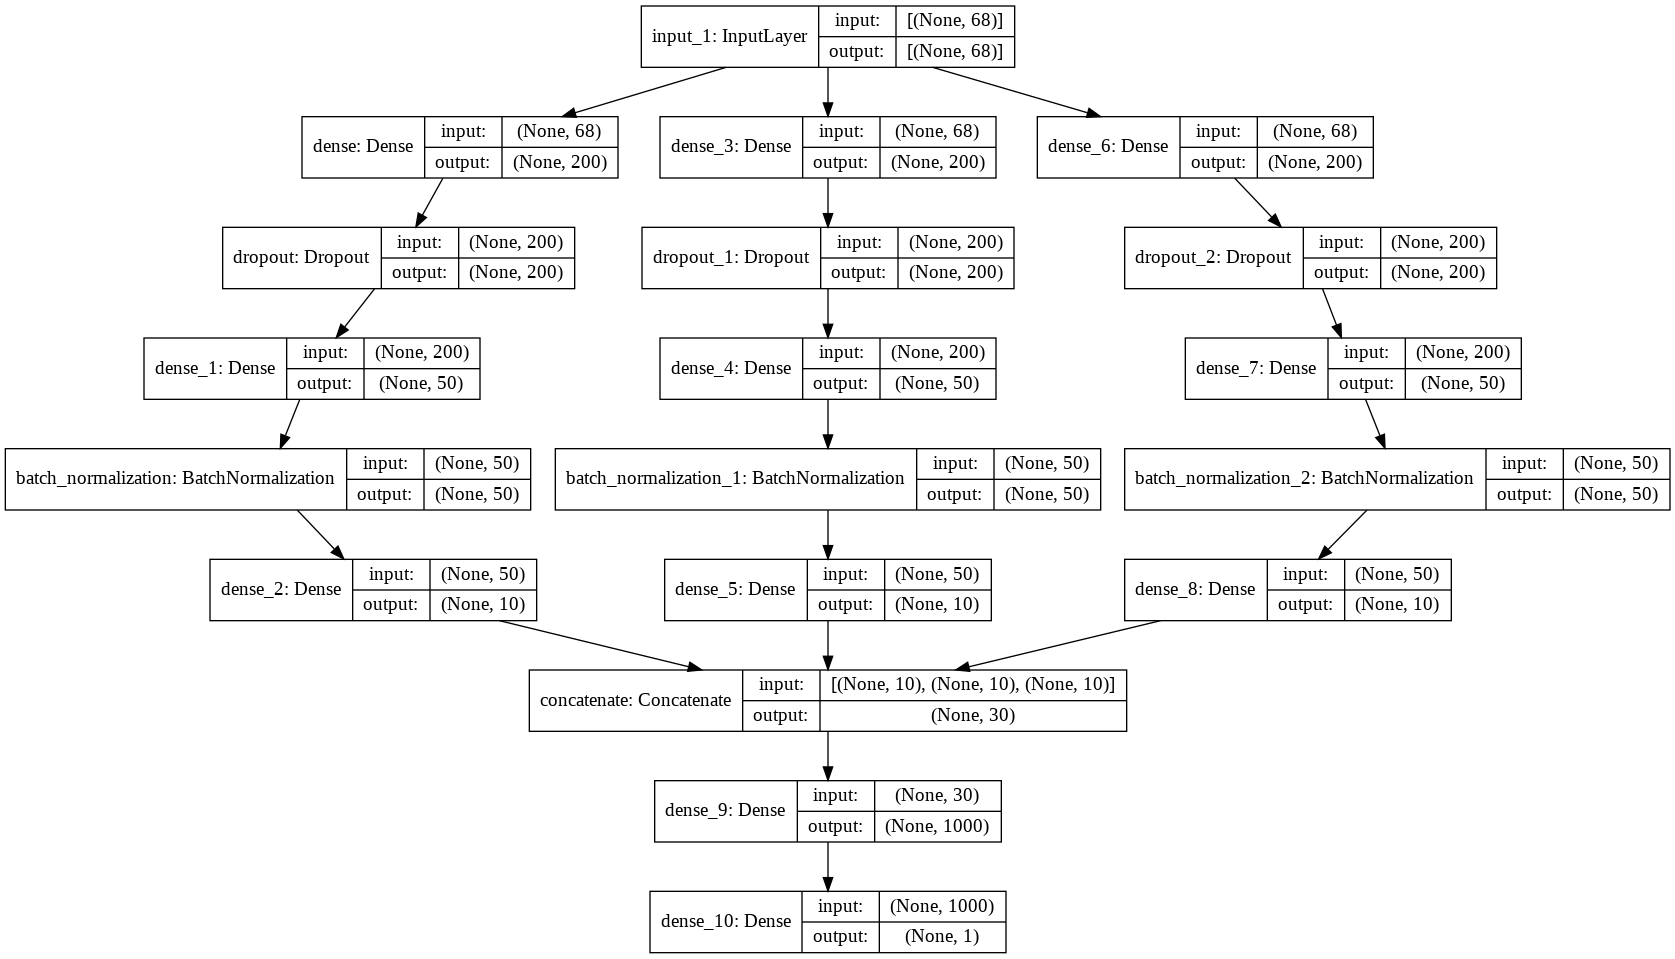

In [16]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          13800       input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 200)          13800       input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 200)          13800       input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
    loss='mse',
    loss_weights=None,
    weighted_metrics=None
)

In [31]:
model.fit(
    x=X_train,
    y=y_train,
    validation_data = (X_test, y_test),
    batch_size=700,
    epochs=2000,
    verbose=2,
    callbacks=None,
    initial_epoch=0,
    workers=-1,
)

Epoch 1/2000
402/402 - 2s - loss: 956.0250 - root_mean_squared_error: 30.7122 - val_loss: 806.7673 - val_root_mean_squared_error: 30.7124
Epoch 2/2000
402/402 - 2s - loss: 956.8892 - root_mean_squared_error: 30.7114 - val_loss: 804.3270 - val_root_mean_squared_error: 30.7120
Epoch 3/2000
402/402 - 2s - loss: 957.1438 - root_mean_squared_error: 30.7102 - val_loss: 805.2976 - val_root_mean_squared_error: 30.7117
Epoch 4/2000
402/402 - 2s - loss: 956.1033 - root_mean_squared_error: 30.7090 - val_loss: 805.3386 - val_root_mean_squared_error: 30.7113
Epoch 5/2000
402/402 - 2s - loss: 957.8271 - root_mean_squared_error: 30.7130 - val_loss: 804.4030 - val_root_mean_squared_error: 30.7110
Epoch 6/2000
402/402 - 2s - loss: 956.4268 - root_mean_squared_error: 30.7087 - val_loss: 806.0034 - val_root_mean_squared_error: 30.7106
Epoch 7/2000
402/402 - 2s - loss: 955.8155 - root_mean_squared_error: 30.7134 - val_loss: 805.0284 - val_root_mean_squared_error: 30.7102
Epoch 8/2000
402/402 - 2s - loss: 

In [32]:
model.save('/content/drive/MyDrive/Data/Model3/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/Model3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/Model3/assets


In [ ]:
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Data/Model3/')

In [ ]:
preds = model.predict(TEST[features])
preds

In [26]:
test = pd.read_csv('cp4_test.csv')
test.columns

Index(['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max'], dtype='object')

In [27]:
TEST.columns

Index(['year', 'month', 'day', 'lat', 'lon', 'distance_from_source',
       'drainage_area', 'z_null', 'aet_12', 'aet_11', 'aet_10', 'aet_9',
       'aet_8', 'aet_7', 'aet_6', 'aet_5', 'aet_4', 'aet_3', 'aet_2', 'aet_1',
       'Cm', 'J', 'K', 'N', 'O', 'X', 'Z', 'horizontal_visibility',
       'cloud_amount_total', 'cloud_base_altitude', 'wind_direction',
       'wind_speed_aver', 'soil_surface_temperature', 'air_temperature',
       'water_vapour_partial_pressure', 'relative_humidity',
       'vapour_pressure_deficit', 'dew_point_temperature', 'pressure',
       'pressure_sea_level', 'barometric_tendency',
       'soil_surface_alco_temperature', 'soil_surface_max_temperature',
       'air_temperature_max_before', 'air_max_temperature', 'weather_before',
       'weather', 'air_temperature_wet_bulb_qual_1',
       'barometric_tendency_characteristic', 'precipitation',
       'snow_coverage_near_station', 'snow_coverage_route', 'ice_crust_route',
       'snow_height_aver', 'snow_density

In [28]:
TEST['delta_stage_max'] = preds
TEST['date'] = test['date']
TEST['station_id'] = test['station_id']

In [29]:
TEST[[ 'year', 'month', 'day', 'station_id', 'date', 'delta_stage_max']].to_csv('submit.csv', index=False)